# HW3 - PART 1

In [1]:
# import the necessary packages
import io
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

(1) Write a function which takes three inputs - (1) an HICP item code (a string), (2) a boolean (True or False) indicating if the series is seasonally adjusted or not, and (3) an indicator whether the series is in levels or as annual rate of change (for example, the parameter can be a string with one of two options - “INX” or “ANR”). The function should download the indicated adjusted or unadjusted HICP series in level (“INX”) or as rate of change (“ANR”) and returns a dataframe with datetime index and one series whose column name shows the item description, geo, and whether it is seasonally adjusted or unadjusted.

In [14]:
def dow(code, tof, loac):
    
    if tof == True: 
        d = 'Y'
        des = 'Season adjust'
        number = '3' 

    if tof == False: 
        d = 'N'
        des = 'Non season adjust'
        number = '4' 
    
    SDW_URL = "https://sdw-wsrest.ecb.europa.eu/service/data"
    series_code = f'ICP/M.U2.{d}.{code}.{number}.{loac}'
    ecburl = f"{SDW_URL}/{series_code}"
    response = requests.get(ecburl, headers={"Accept": "text/csv"})
    assert response.status_code == 200, 'Failed to get a correct reponse'

    df_series = pd.read_csv(io.StringIO(response.text))
    df_series = df_series[["TIME_PERIOD", "OBS_VALUE", "TITLE"]].copy()

    df_series.columns.values[0]='date'
    df_series.columns.values[1]=df_series.iloc[1,2], 'U2', des 
    new_index = pd.to_datetime(df_series.date)
    df_series.index=new_index
    df_series.drop('TITLE', axis=1, inplace=True)

    df_series.drop('date', axis=1, inplace=True)
    
    return df_series

</div> <div class="alert alert-block alert-danger">
    
the `dow()` function with some modifications to consider

In [33]:
def dow_v2(code, tof, loac):
    # use if ... else (for bools there is no need to write == True)
    if tof: 
        d = 'Y'
        des = 'Season adjust'
        number = '3' 
    else:
        d = 'N'
        des = 'Non season adjust'
        number = '4' 
    
    SDW_URL = "https://sdw-wsrest.ecb.europa.eu/service/data"
    series_code = f'ICP/M.U2.{d}.{code}.{number}.{loac}'
    ecburl = f"{SDW_URL}/{series_code}"
    response = requests.get(ecburl, headers={"Accept": "text/csv"})
    assert response.status_code == 200, 'Failed to get a correct reponse'

    df_series = pd.read_csv(io.StringIO(response.text))
    # capture the name and geo here
    title = df_series['TITLE'][0]
    ctry = df_series['REF_AREA'][0] 
    df_series = df_series[['TIME_PERIOD', 'OBS_VALUE']].copy() 
    # set datetime index
    df_series.set_index(pd.to_datetime(df_series.loc[:,'TIME_PERIOD']), inplace=True)
    # rename only the relevant column, using f-string
    df_series.rename(columns={'OBS_VALUE': f'{title}, {ctry}, {des}'}, inplace=True)
    df_series.index.name = 'date'
    return df_series.drop('TIME_PERIOD', axis=1)

#(2) Using the function from (1) download HICP in levels for U2, seasonally adjusted and unadjusted

In [34]:
#seasonally adjusted
df_hicp_adj=dow('000000', True, 'INX')
df_hicp_adj.head()

,"(HICP - Overall index, U2, Season adjust)"
date,
1997-01-01,72.81588
1997-02-01,72.79133
1997-03-01,72.77145
1997-04-01,72.76301
1997-05-01,72.86881


In [35]:
df_hicp_adj2=dow_v2('000000', True, 'INX')
df_hicp_adj2.head()

,"HICP - Overall index, U2, Season adjust"
date,
1997-01-01,72.81588
1997-02-01,72.79133
1997-03-01,72.77145
1997-04-01,72.76301
1997-05-01,72.86881


In [36]:
#seasonally unadjusted
df_hicp_unadj=dow('000000', False, 'INX')
df_hicp_unadj.head()

,"(HICP - Overall index, U2, Non season adjust)"
date,
1996-01-01,70.97
1996-02-01,71.29
1996-03-01,71.54
1996-04-01,71.66
1996-05-01,71.83


In [37]:
df_hicp_unadj2=dow_v2('000000', False, 'INX')
df_hicp_unadj2.head()

,"HICP - Overall index, U2, Non season adjust"
date,
1996-01-01,70.97
1996-02-01,71.29
1996-03-01,71.54
1996-04-01,71.66
1996-05-01,71.83


#(3) Compute year on year inflation rates as per cent change from the previous year

In [39]:
infl_perc = pd.concat([df_hicp_adj.pct_change(periods=12)*100,df_hicp_unadj.pct_change(periods=12)*100], axis=1)
infl_perc.tail()

,"(HICP - Overall index, U2, Season adjust)","(HICP - Overall index, U2, Non season adjust)"
date,,
2021-10-01,4.119661,4.051355
2021-11-01,4.745940,4.866412
2021-12-01,4.971668,4.964337
2022-01-01,5.080920,5.108242
2022-02-01,5.831616,5.874550


#(4) Compute year on year inflation rates as the 12-month difference in the log of the series

In [43]:
infl_log = pd.concat([np.log(df_hicp_adj).diff(periods=12)*100,np.log(df_hicp_unadj).diff(periods=12)*100], axis=1)
infl_log.tail()

,"(HICP - Overall index, U2, Season adjust)","(HICP - Overall index, U2, Non season adjust)"
date,,
2021-10-01,4.037064,3.971439
2021-11-01,4.636761,4.751709
2021-12-01,4.852030,4.845046
2022-01-01,4.956054,4.982051
2022-02-01,5.667911,5.708472


</div> <div class="alert alert-block alert-danger">
May be simpler to first merge the downloaded series and then do the two transformations

In [46]:
df_hicp_level = pd.concat([df_hicp_adj, df_hicp_unadj], axis=1)
# alternatively (this will keep only dates where both series have non-missing values )
df_hicp_level = df_hicp_adj.merge(df_hicp_unadj, left_index=True, right_index=True)
df_hicp_level.head()

,"(HICP - Overall index, U2, Season adjust)","(HICP - Overall index, U2, Non season adjust)"
date,,
1997-01-01,72.81588,72.42
1997-02-01,72.79133,72.59
1997-03-01,72.77145,72.65
1997-04-01,72.76301,72.60
1997-05-01,72.86881,72.80


In [47]:
infl_perc_2 = df_hicp_level.pct_change(periods=12)*100
infl_perc_2.tail()

,"(HICP - Overall index, U2, Season adjust)","(HICP - Overall index, U2, Non season adjust)"
date,,
2021-10-01,4.119661,4.051355
2021-11-01,4.745940,4.866412
2021-12-01,4.971668,4.964337
2022-01-01,5.080920,5.108242
2022-02-01,5.831616,5.874550


In [48]:
infl_log_2 = np.log(df_hicp_level).diff(periods=12)*100
infl_log_2.tail()

,"(HICP - Overall index, U2, Season adjust)","(HICP - Overall index, U2, Non season adjust)"
date,,
2021-10-01,4.037064,3.971439
2021-11-01,4.636761,4.751709
2021-12-01,4.852030,4.845046
2022-01-01,4.956054,4.982051
2022-02-01,5.667911,5.708472


#(5) Using the function from (1) download HICP in annual rate of change for U2, seasonally unadjusted.

In [49]:
df_hicp_unadj_anr=dow('000000', False, 'ANR')
df_hicp_unadj_anr

,"(HICP - Overall index, U2, Non season adjust)"
date,
1997-01-01,2.0
1997-02-01,1.8
1997-03-01,1.6
1997-04-01,1.3
1997-05-01,1.4
...,...
2021-10-01,4.1
2021-11-01,4.9
2021-12-01,5.0


#(6) Make a 2 by 2 plot showing each one of the four inflation series you calculated in (3) and (4) (per cent change adjusted and unadjusted, log-diff adjusted and unadjusted) and the ANR series you downloaded in (5).

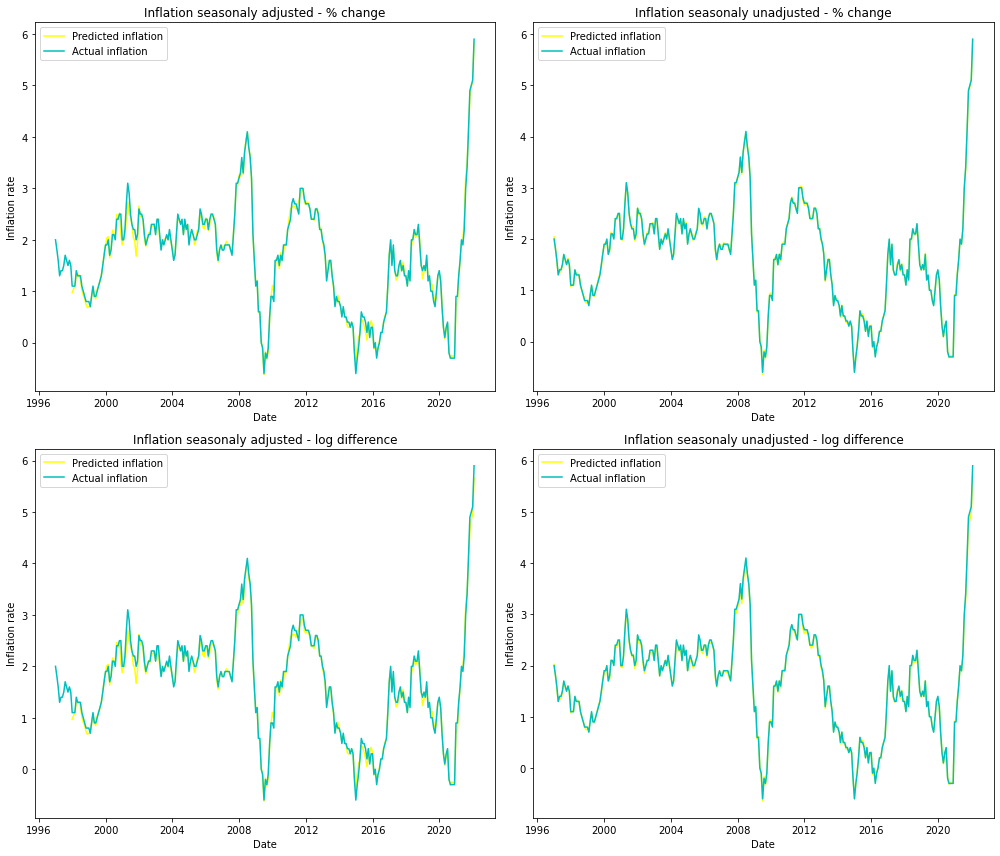

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(14,12))
axs[0, 0].plot(infl_perc.index, infl_perc.iloc[:,0], label='Predicted inflation', color='yellow')
axs[0, 0].plot(df_hicp_unadj_anr.index, df_hicp_unadj_anr.iloc[:,0], label='Actual inflation', color='c')
axs[0, 0].set_title('Inflation seasonaly adjusted - % change')
axs[0, 0].legend()
axs[0, 1].plot(infl_perc.index, infl_perc.iloc[:,1], label='Predicted inflation', color='yellow')
axs[0, 1].plot(df_hicp_unadj_anr.index, df_hicp_unadj_anr.iloc[:,0], label='Actual inflation', color='c')
axs[0, 1].legend()
axs[0, 1].set_title('Inflation seasonaly unadjusted - % change')
axs[1, 0].plot(infl_log.index, infl_log.iloc[:,0], label='Predicted inflation', color='yellow')
axs[1, 0].plot(df_hicp_unadj_anr.index, df_hicp_unadj_anr.iloc[:,0], label='Actual inflation', color='c')
axs[1, 0].set_title('Inflation seasonaly adjusted - log difference')
axs[1, 0].legend()
axs[1, 1].plot(infl_log.index, infl_log.iloc[:,1], label='Predicted inflation', color='yellow')
axs[1, 1].plot(df_hicp_unadj_anr.index, df_hicp_unadj_anr.iloc[:,0], label='Actual inflation', color='c')
axs[1, 1].set_title('Inflation seasonaly unadjusted - log difference')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Inflation rate')
    
plt.tight_layout()


</div> <div class="alert alert-block alert-danger">

Its a good plot to use `sharex` and `sharey`

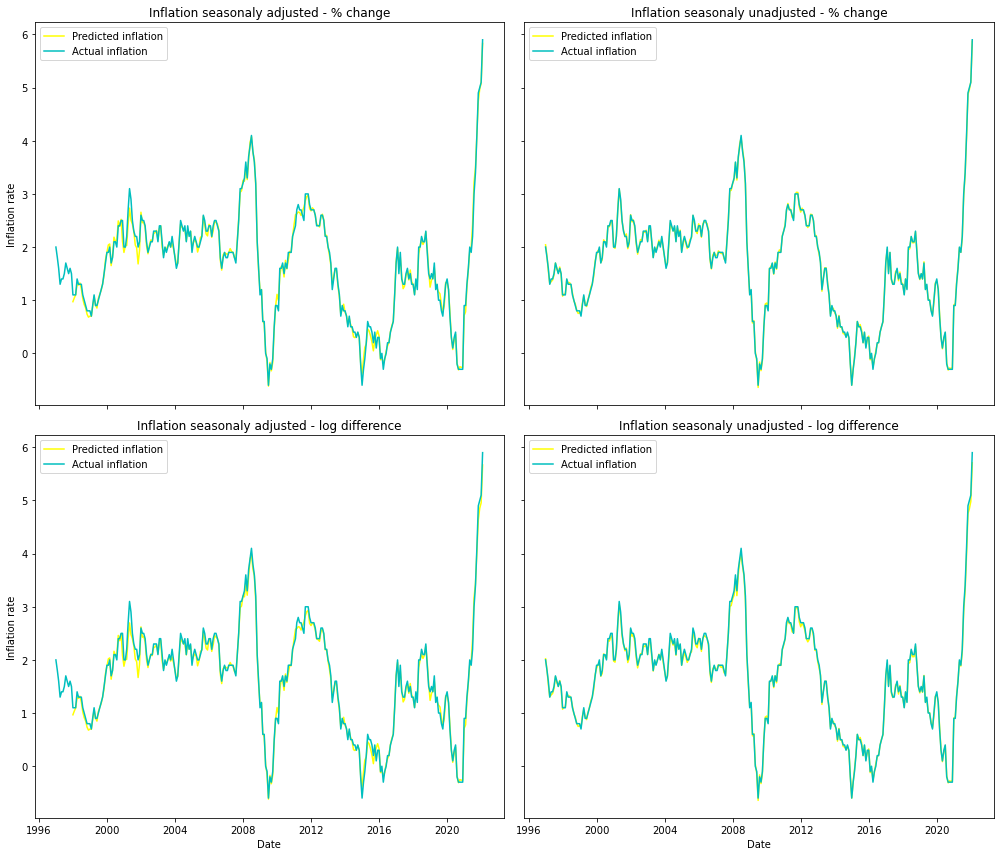

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(14,12), sharex=True, sharey=True)
axs[0, 0].plot(infl_perc.index, infl_perc.iloc[:,0], label='Predicted inflation', color='yellow')
axs[0, 0].plot(df_hicp_unadj_anr.index, df_hicp_unadj_anr.iloc[:,0], label='Actual inflation', color='c')
axs[0, 0].set_title('Inflation seasonaly adjusted - % change')
axs[0, 0].legend()
axs[0, 1].plot(infl_perc.index, infl_perc.iloc[:,1], label='Predicted inflation', color='yellow')
axs[0, 1].plot(df_hicp_unadj_anr.index, df_hicp_unadj_anr.iloc[:,0], label='Actual inflation', color='c')
axs[0, 1].legend()
axs[0, 1].set_title('Inflation seasonaly unadjusted - % change')
axs[1, 0].plot(infl_log.index, infl_log.iloc[:,0], label='Predicted inflation', color='yellow')
axs[1, 0].plot(df_hicp_unadj_anr.index, df_hicp_unadj_anr.iloc[:,0], label='Actual inflation', color='c')
axs[1, 0].set_title('Inflation seasonaly adjusted - log difference')
axs[1, 0].legend()
axs[1, 1].plot(infl_log.index, infl_log.iloc[:,1], label='Predicted inflation', color='yellow')
axs[1, 1].plot(df_hicp_unadj_anr.index, df_hicp_unadj_anr.iloc[:,0], label='Actual inflation', color='c')
axs[1, 1].set_title('Inflation seasonaly unadjusted - log difference')
axs[1, 1].legend()

# xlabel for bottom axes only (alternately use ax[0,0].set(...) and ax[1, 0].set(...))
for ax in axs.flat[-2:]:
    ax.set(xlabel='Date')

# y label for left aves only (alternately use ax[1,0].set(...) and ax[1, 1].set(...))   
for ax in axs.flat[0:3:2]:
    ax.set(ylabel='Inflation rate')
    
plt.tight_layout()


#(7) Which of the two methods you used produces inflation series that is closer to the official inflation data?

In [57]:
#to solve this exercice an OLS-type approach was followed. 
#So, the series closer to the actual data is the one that minimizes the sum square resid.
#becasue actual inflation is computed based on unadjusted data, the same approach was considered here.

dif_perc_unadj = ((infl_perc.iloc[:,1] - df_hicp_unadj_anr.iloc[:,0])**2).sum()
dif_log_unadj = ((infl_log.iloc[:,1] - df_hicp_unadj_anr.iloc[:,0])**2).sum()

self_calculayed = {
    'percentage difference': dif_perc_unadj,
    'log difference': dif_log_unadj
}

minim = min(self_calculayed, key=self_calculayed.get)

print(f'Computing inflation based on {minim} produces a series that is closer to the official inflation data.')

Computing inflation based on percentage difference produces a series that is closer to the official inflation data.
